# Loading GHN-3 and Predicting Parameters for all PyTorch ImageNet models 

## Paper: Can We Scale Transformers to Predict Parameters of Diverse ImageNet Models?  https://arxiv.org/abs/2303.04143

In [1]:
# Import required modules
import inspect
import types
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import joblib
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
from ghn3_utils import from_pretrained
from ppuda.deepnets1m.graph import GraphBatch
from graph import Graph


print('torch', torch.__version__)
print('torchvision', torchvision.__version__)
print('Make sure PyTorch: >= 1.12.1 and Torchvision >= 0.13.1 are installed to make our code work properly')

torch 1.12.1+cpu
torchvision 0.13.1+cpu
Make sure PyTorch: >= 1.12.1 and Torchvision >= 0.13.1 are installed to make our code work properly


### Load GHN-3

As the model takes about 2.5GB, it takes a while to download the model.

The model is downloaded from HuggingFace: https://huggingface.co/SamsungSAILMontreal/ghn3/tree/main.

In [8]:
ghn = from_pretrained()

loading GHN-3 done!


### Predict parameters for ResNet-50 and compare to the downloaded ResNet-50 for sanity check

Parameter prediction for ResNet-50 done in 2.810 seconds


Downloading:   0%|          | 0.00/103M [00:00<?, ?B/s]

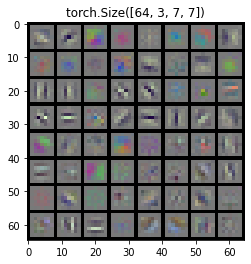

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50()
graph = Graph(model)
# graph.visualize()  # to visualize ResNet-50 graph
start = time.time()
model = ghn(model, GraphBatch([graph]).to_device(device))
print('Parameter prediction for ResNet-50 done in %.3f seconds' % (time.time() - start))

weights = model.conv1.weight.data.cpu()
grid = torchvision.utils.make_grid(weights, nrow=8, normalize=True, padding=1)
plt.figure(figsize=(4, 4))
plt.title(weights.shape)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

model_sanity_check = models.resnet50()
model_sanity_check.load_state_dict(joblib.load(hf_hub_download(repo_id='SamsungSAILMontreal/ghn3',
                                                               filename='resnet50_ghn3xlm16_init.pt'))['state_dict'])

dict1 = dict(model.named_parameters())
for n, p in model_sanity_check.named_parameters():
    if not torch.allclose(p, dict1[n], atol=1e-6):
        print('warning: big discrepancy {:.3e} for param: {}'.format(torch.norm(p - dict1[n]), n))        

## Predict parameters for all PyTorch models

In [7]:
# Enumerate all PyTorch models of ImageNet classification
# Should be >= 74 models in torchvision>=0.13.1
all_torch_models = []
for m in dir(models):
    if m[0].isupper() or m.startswith('_') or m.startswith('get') or \
      not inspect.isfunction(eval('models.%s' % m)):
        continue
    
    if m in ['vit_h_14', 'regnet_y_128gf']:
        print('%s was not added in PyTorch at the moment of GHN-3 evaluation resulting in 74 models in total' % m.upper())
        continue  # skip for consistency with the paper
        
    all_torch_models.append(m)
    
print('%d PyTorch models found' % len(all_torch_models))    
            
for m in all_torch_models:
    kw_args = {'aux_logits': False, 'init_weights': False} if m == 'googlenet' else {}

    # Predict parameters
    model = eval(f'models.{m}(**kw_args)')
    n_params = sum([p.numel() for p in model.parameters()]) / 10**6
    if m == 'inception_v3':
        model.expected_input_sz = 299
    print('Predicting parameters for {} with {:.2f}M parameters'.format(m, n_params), flush=True)
    model = ghn(model, GraphBatch([Graph(model)]).to_device(device))
    
    # "WARNING: number of predicted ..." means that some layers in the model are not supported by the GHN

print('done!')

REGNET_Y_128GF was not added in PyTorch at the moment of GHN-3 evaluation resulting in 74 models in total
VIT_H_14 was not added in PyTorch at the moment of GHN-3 evaluation resulting in 74 models in total
74 PyTorch models found
Predicting parameters for alexnet with 61.10M parameters
Predicting parameters for convnext_base with 88.59M parameters
Predicting parameters for convnext_large with 197.77M parameters
Predicting parameters for convnext_small with 50.22M parameters
Predicting parameters for convnext_tiny with 28.59M parameters
Predicting parameters for densenet121 with 7.98M parameters
Predicting parameters for densenet161 with 28.68M parameters
Predicting parameters for densenet169 with 14.15M parameters
Predicting parameters for densenet201 with 20.01M parameters
Predicting parameters for efficientnet_b0 with 5.29M parameters
Predicting parameters for efficientnet_b1 with 7.79M parameters
Predicting parameters for efficientnet_b2 with 9.11M parameters
Predicting parameters f

C:\envs\torch\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Predicting parameters for inception_v3 with 27.16M parameters
Predicting parameters for mnasnet0_5 with 2.22M parameters
Predicting parameters for mnasnet0_75 with 3.17M parameters
Predicting parameters for mnasnet1_0 with 4.38M parameters
Predicting parameters for mnasnet1_3 with 6.28M parameters
Predicting parameters for mobilenet_v2 with 3.50M parameters
Predicting parameters for mobilenet_v3_large with 5.48M parameters
Predicting parameters for mobilenet_v3_small with 2.54M parameters
Predicting parameters for regnet_x_16gf with 54.28M parameters
Predicting parameters for regnet_x_1_6gf with 9.19M parameters
Predicting parameters for regnet_x_32gf with 107.81M parameters
Predicting parameters for regnet_x_3_2gf with 15.30M parameters
Predicting parameters for regnet_x_400mf with 5.50M parameters
Predicting parameters for regnet_x_800mf with 7.26M parameters
Predicting parameters for regnet_x_8gf with 39.57M parameters
Predicting parameters for regnet_y_16gf with 83.59M parameters
P